In [5]:
using PyPlot, Statistics, LinearAlgebra, JLD, SparseArrays

In [6]:
function stabledim(lyapexp::Array{T}) where T
    @assert all(lyapexp .!= 0)
    any(lyapexp .> 0) || return zero(T)
    slx = sort(lyapexp,rev=true)
    lcs = cumsum(slx)
    u = findfirst(slx .<= 0); u == nothing && (u = length(slx))
    k = findfirst(lcs .<= 0); k == nothing && return convert(T,length(slx)+1 - u)
    k + lcs[k-1]/(-slx[k]) - u
end
    

stabledim (generic function with 1 method)

In [14]:
function smap(x,p)
    (1-p[1]*x[1]^2+p[2]*x[end],x[1:end-1]...)
end
function Jsmap(x,p)
    n = length(x)
    sparse([2:n;1;1],[1:n;1],[ones(n-1);p[2];-2p[1]*x[1]])
#     M = diagm(-1=>ones(length(x)-1))
#     M[1,1] = -2p[1]*x[1]
#     M[1,end] = p[2]
#     M
end


Jsmap (generic function with 1 method)

In [ ]:
# ds_aim = d-1/(1+(1.4 - log(xi))/0.5)
# # K = 10.; ϵ = 1.3
# # 
# α0 = 0.5; β0 = 1.4
# d = 12; ds_aim = 1.;
# a = 3.9; xi = 1. #min(exp(β0 - (d-1-ds_aim)*α0/ds_aim),1); 
# println("ξ = $xi")
# p = (a,xi)


In [13]:

x = smap(0.1rand(d),p)
orthoLV = Matrix{Float64}(I,length(x),length(x))
lyap = zeros(length(x))
for i = 1:1000
    orthoLV, _ = qr(Jsmap(x,p)*orthoLV)
    x = smap(x,p)
end
N = 400000
x1h = Array{Float64}(undef,N)
x2h = Array{Float64}(undef,N)
x3h = Array{Float64}(undef,N)
for i = 1:N
    Jsmapx = Jsmap(x,p)
    orthoLV, R = qr(Jsmapx*orthoLV)
    lyap += log.(abs.(diag(R)))
    x = smap(x,p)
    x1h[i] = x[1]
    x2h[i] = Jsmapx[1,1]
    x3h[i] = Jsmapx[1,end]
end
any((~).(isfinite.(x1h))) && error("Infinite values detected")
lyap /= N
α = mean(log.(abs.(x2h))); β = -mean(log.(abs.(x3h)))
cumsum(lyap)
stabledim(lyap), (d-1)*α/(α+β)

ξ = 1.0


(3.6031614903541103, 3.0108565819078903)

In [55]:
2*0.58/(2α + β - log(exp(α)^2+exp(2α)^2)/2)

0.9136681120933569

In [46]:
2*0.55/(β-log(sqrt(1+exp(α)^2))+2α)

0.6099432435169254

In [28]:
lyap

7-element Array{Float64,1}:
  0.5340407333483985 
 -0.26345268475310996
 -0.28955175561476204
 -0.3136207460716749 
 -0.33944996811360717
 -0.3616619246770211 
 -0.38366422103469866

In [281]:
# 1 + (1 + β/α)*1.5
α, β

(0.5344931440418912, 1.4161422157541026)

In [262]:
sum(lyap), maximum(lyap), mean(log.(abs.(x3h))),mean(log.(abs.(x2h)))

(-1.415966822959281, 0.5346392240972632, -1.4159668229592777, 0.5343532999236382)

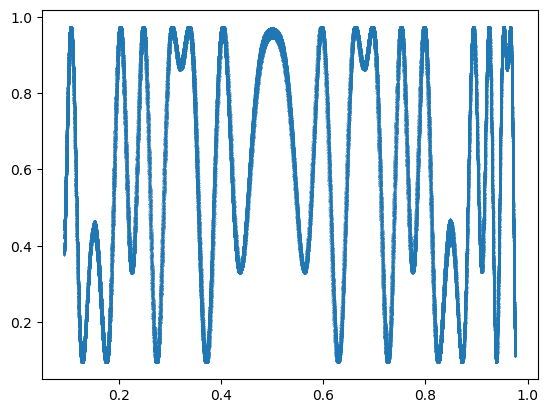

PyObject <matplotlib.collections.PathCollection object at 0x16095d110>

In [302]:
scatter(x1h[1:end-d+1],x1h[d:end],s=0.01)
# xlim(0.2,0.4);ylim(-3.6,-3)

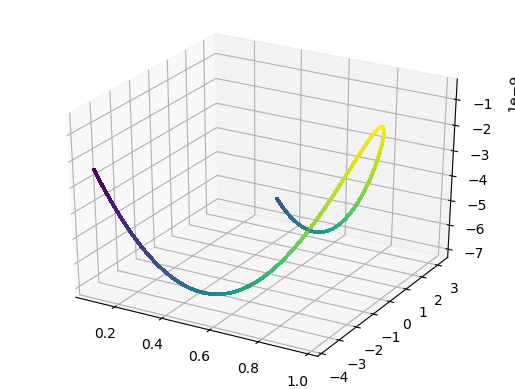

PyObject <mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x144276090>

In [289]:
scatter3D(x1h,x2h,x3h,s=1,c=x1h)

In [263]:
xivals = range(0.5,1.0,length=501)
runs = 10; N = 1000000
respvals = Array{Float64}(undef,runs,length(xivals))
stabledimvals = Array{Float64}(undef,runs,length(xivals))
for (n,xi) in enumerate(xivals)
    for run = 1:runs
        p = (3.9,xi,5)
        x = smap(rand(5),p)
#         lyv = Matrix{Float64}(I,length(x),length(x))
        for i = 1:10000
            x = smap(x,p)
#             lyv, _ = qr(Jsmap(x,p)*lyv)
        end
        obs = 0.
        for i = 1:N
            x = smap(x,p)
            obs += x[1]
        end
        respvals[run,n] = obs/N
    end
end

InterruptException: InterruptException:

In [219]:
xivals = range(0.5,1.0,length=101)
runs_sd = 10; N_sd = 40000
sdimvals = Array{Float64}(undef,runs_sd,length(xivals_sd))
for (n,xi) in enumerate(xivals_sd)
    for run = 1:runs_sd
        p = (3.9,xi,5)
        x = smap(rand(5),p)
        lyv = Matrix{Float64}(I,length(x),length(x))
        for i = 1:10000
            lyv, _ = qr(Jsmap(x,p)*lyv)
            x = smap(x,p)
        end
        lyap = zeros(Float64,length(x))
        for i = 1:N_sd
            lyv, R = qr(Jsmap(x,p)*lyv)
            lyap += log.(abs.(diag(R)))
            x = smap(x,p)
        end
        sdimvals[run,n] = stabledim(lyap/N_sd)
    end
end

InterruptException: InterruptException:

0.30825911664437420.40291312555057157
0.

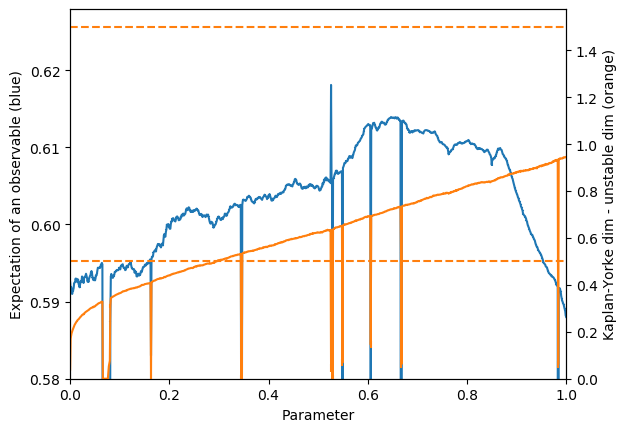

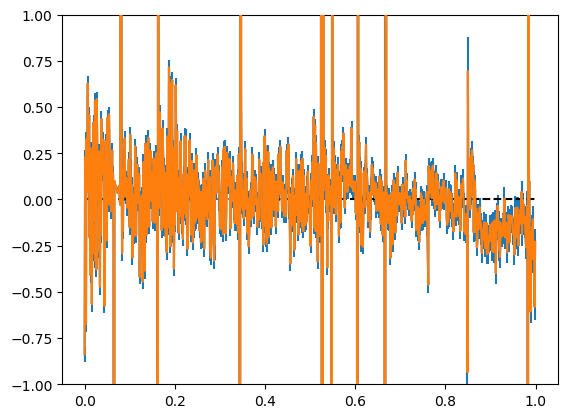

001


In [19]:
let 
    @load "Stable dimension calculation - delay4.jld"
#     xivals[findfirst(vec(mean(sdimvals,dims=1)) .> 0.5)]|>println
#     println(xivals[981]," ",mean(sdimvals[:,981]),"±",2std(sdimvals[:,981])/sqrt(runs))
#     scatter(repeat(xivals',1,runs),respvals.+0.06xivals',s=1)
    mrv = vec(mean(respvals,dims=1)); srv = vec(std(respvals,dims=1))/sqrt(runs)
        println(median(sdimvals,dims=1)[51],median(sdimvals,dims=1)[151])
    errorbar(xivals,mrv.+0.06xivals,2srv)
    xlim(extrema(xivals)); ylim(ymin=0.58)
    xlabel("Parameter"); ylabel("Expectation of an observable (blue)")
    if @isdefined sdimvals
        ax2 = gca().twinx()
    #         scatter(repeat(xivals_sd',1,runs_sd),sdimvals,s=1,c="C1")
        errorbar(xivals_sd,vec(median(sdimvals,dims=1)),min.(0.05,2vec(std(sdimvals,dims=1)))/sqrt(runs_sd),c="C1")
        plot(xivals_sd,fill(1.5,length(xivals_sd)),"--",c="C1")
        plot(xivals_sd,fill(0.5,length(xivals_sd)),"--",c="C1")
    #     plot(xivals_sd,fill(1.0,length(xivals_sd)),"--",c="C1")
    #     ylabel("Kaplan-Yorke \"stable dimension\" (orange)")
        ylabel("Kaplan-Yorke dim - unstable dim (orange)")
#         ylim(0,2)
        ylim(ymin=0)
#         plot(xivals_sd,(12 - 1) ./(1 .+ (1.4 .- log.(xivals_sd))/0.5))
    end
#     title("Delay time = 7")
#     savefig("Response vs KY minus unstable-adfsadfdsf.pdf")
    figure(2)
    mrv
    errorbar(xivals[1:end-1],(diff(mrv.+0.06xivals))./diff(xivals),2hypot.(srv[2:end],srv[1:end-1])./diff(xivals))#,2vec(std(respvals,dims=1))/sqrt(runs))
    plot(xivals[1:end-1],(diff(mrv.+0.06xivals))./diff(xivals),zorder=3)#,2vec(std(respvals,dims=1))/sqrt(runs))

    plot([0,1],[0,0],"k--")
    ylim(-1,1)
#     semilogy()
    println(xivals[2]-xivals[1])
end

## Exponential mixing?

In [8]:
lyap = zeros(length(x))
for i = 1:1000
    orthoLV, _ = qr(Jsmap(x,p)*orthoLV)
    x = smap(x,p)
end
Nmx = 10^6
xhmx = Array{Float64}(undef,Nmx)
for i = 1:Nmx
    x = smap(x,p)
    xhmx[i] = x[1]
end

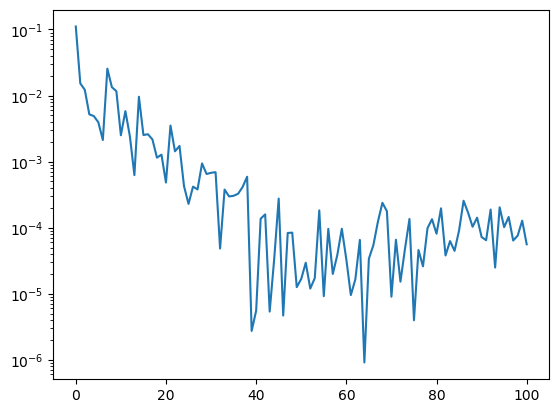

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1298a7b90>

In [11]:
using Statistics
semilogy(0:100,abs.([cov(xhmx[1:end-i],xhmx[i+1:end]) for i = 0:100]))